In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
# Import ImageDataGenerator from tensorflow.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
# Instead of importing from experimental, import directly from keras.layers.preprocessing
#from tensorflow.keras.layers import preprocessing


# System libraries
from pathlib import Path
import os.path
import random
from collections import Counter

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns
from cycler import cycler
import textwrap

sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [7]:
# Create helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot


BATCH_SIZE = 64
TARGET_SIZE = (300, 300)
# Walk through each directory
dataset = "/content/drive/MyDrive/Alzheimers-image-Classification"
# walk_through_dir(dataset);

--2024-12-02 15:47:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-12-02 15:47:20 (53.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [9]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)

    # Seed value for NumPy
    np.random.seed(seed)

    # Seed value for Python's random library
    random.seed(seed)

    # In TensorFlow 2.x, session management is handled differently.
    # You no longer need to explicitly set the session.
    # The following lines are removed:
    # session_conf = tf.compat.v1.ConfigProto(
    #     intra_op_parallelism_threads=1,
    #     inter_op_parallelism_threads=1
    # )

    # tf.compat.v1.set_random_seed(seed)

    # sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    # tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

In [10]:
def create_image_dataframe(dataset_path: str) -> pd.DataFrame:
    image_dir = Path(dataset_path)

    # Get filepaths for various extensions
    filepaths = list(image_dir.glob(r'**/*.JPG')) + \
                list(image_dir.glob(r'**/*.jpg')) + \
                list(image_dir.glob(r'**/*.png')) + \
                list(image_dir.glob(r'**/*.PNG'))

    # Extract labels from filepaths
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    # Convert lists to Series
    filepaths_series = pd.Series(filepaths, name='Filepath').astype(str)
    labels_series = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels into a DataFrame
    image_df = pd.concat([filepaths_series, labels_series], axis=1)

    return image_df

# Usage
test_dataset = "/content/drive/MyDrive/Alzheimers-image-Classification/test_images"
train_dataset = "/content/drive/MyDrive/Alzheimers-image-Classification/train_images"

test_df = create_image_dataframe(test_dataset)
train_df = create_image_dataframe(train_dataset)

In [11]:
test_df.head(6)

,Filepath,Label
0,/content/drive/MyDrive/Alzheimers-image-Classi...,ModerateDemented
1,/content/drive/MyDrive/Alzheimers-image-Classi...,ModerateDemented
2,/content/drive/MyDrive/Alzheimers-image-Classi...,ModerateDemented
3,/content/drive/MyDrive/Alzheimers-image-Classi...,ModerateDemented
4,/content/drive/MyDrive/Alzheimers-image-Classi...,ModerateDemented
5,/content/drive/MyDrive/Alzheimers-image-Classi...,ModerateDemented


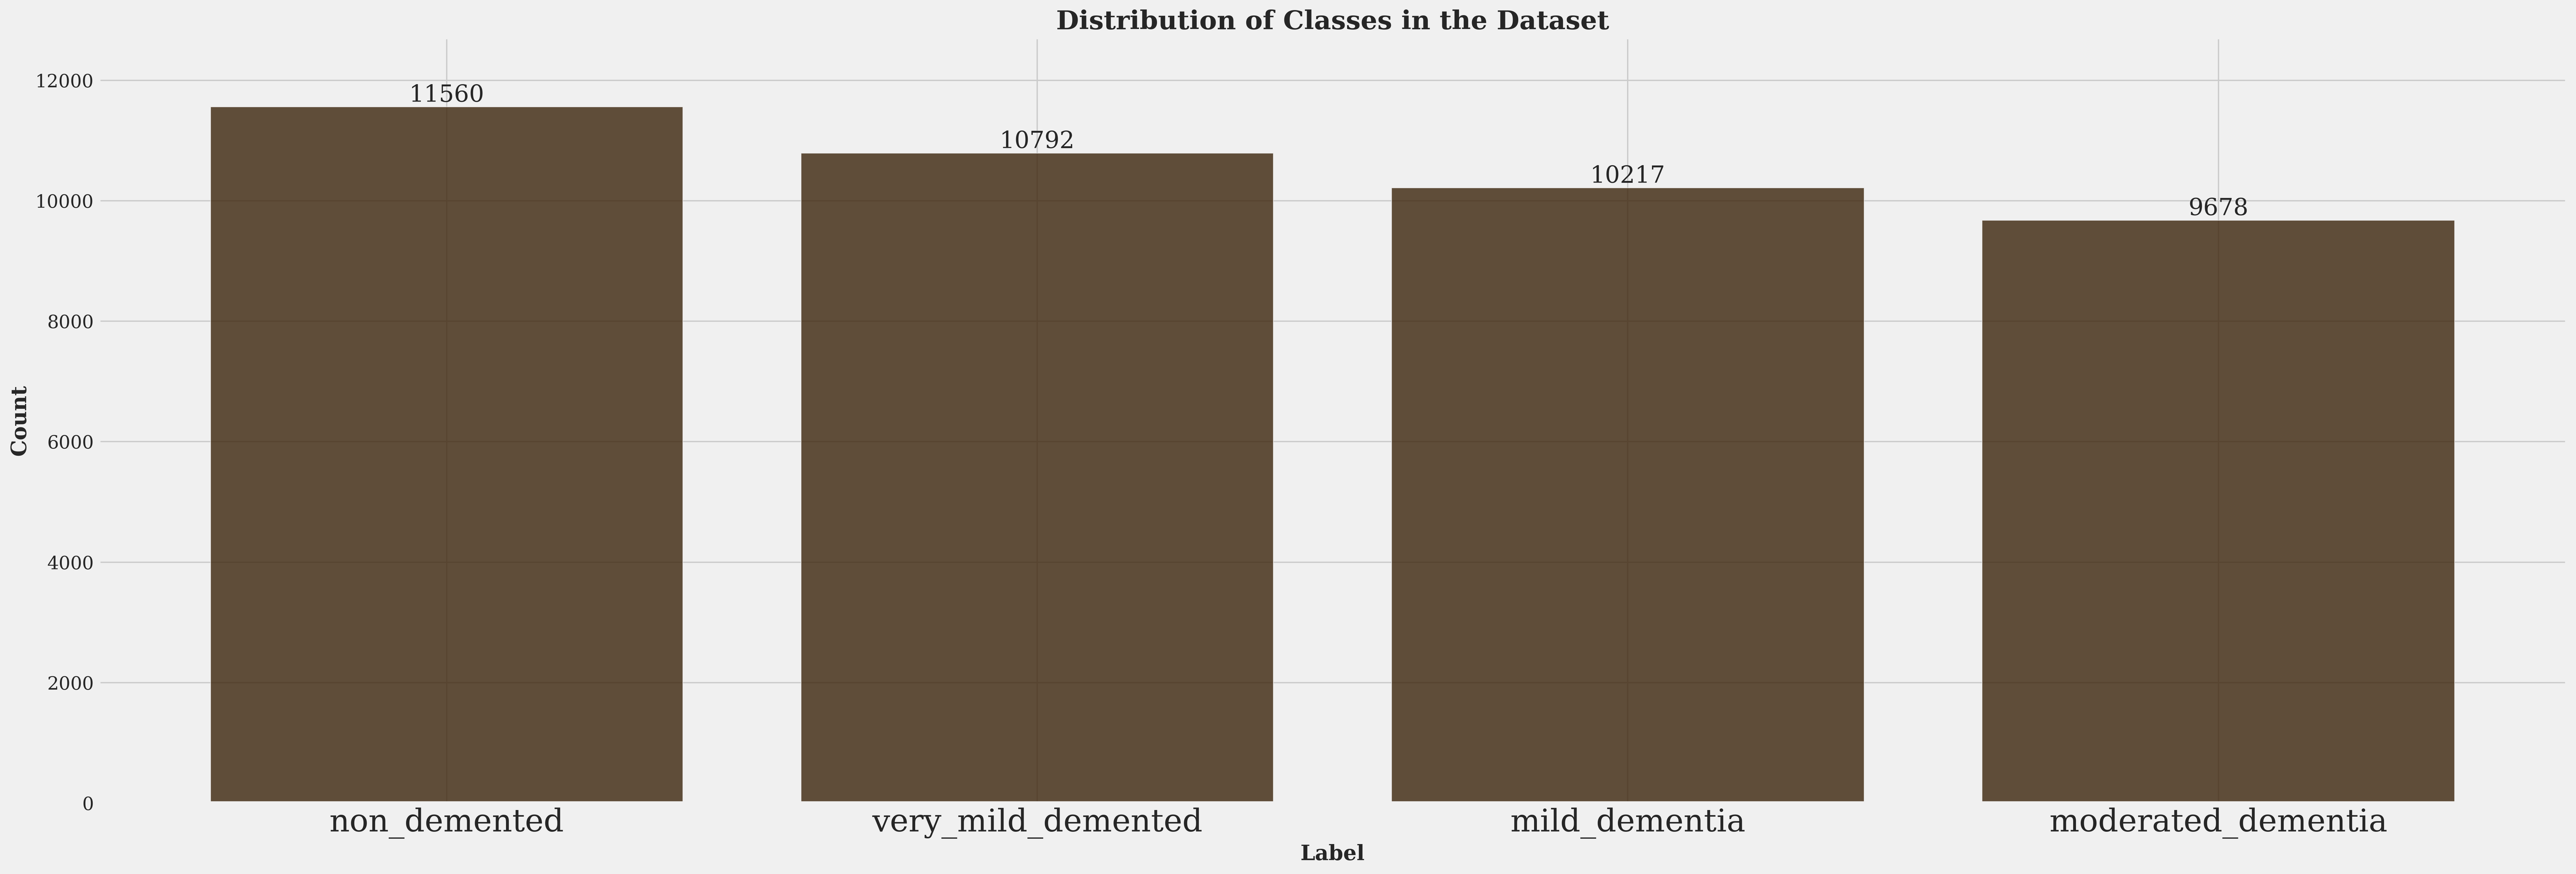

In [12]:
plt.style.use('fivethirtyeight')

# Get the labels
label_counts = train_df['Label'].value_counts()[:]

# Create a cycler object using the desired colors
color_cycler = (cycler(color=["#3B240B"]))  # Darker coffee brown color

# Set the property cycle of the axes to the created cycler object
plt.rc('axes', prop_cycle=color_cycler)

# Other styling options
plt.rc("font", family="serif", size=18.)
plt.rc("savefig", dpi=200)
plt.rc("legend", loc="best", fontsize="medium", fancybox=True, framealpha=0.5)
plt.rc("lines", linewidth=2.5, markersize=10, markeredgewidth=2.5)

plt.figure(figsize=(30, 10), dpi=300)  # Increase figure size
bars = plt.bar(label_counts.index, label_counts.values, alpha=0.8)
plt.title('Distribution of Classes in the Dataset', fontsize=20, fontweight='bold')
plt.xlabel('Label', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=16, fontweight='bold')

# Wrap x-labels
plt.xticks(range(len(label_counts.index)), label_counts.index, fontsize=12, ha='center')  # Use original labels without wrapping

plt.yticks(fontsize=14)
plt.xticks(fontsize=24)

# Adjust y limit to avoid overlapping
plt.ylim(0, max(label_counts) * 1.1)  # Set y limit 10% higher than the max value

# Add value annotations on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, int(yval), ha='center', va='bottom')

plt.show()

# 🔭Visualizing images from the dataset

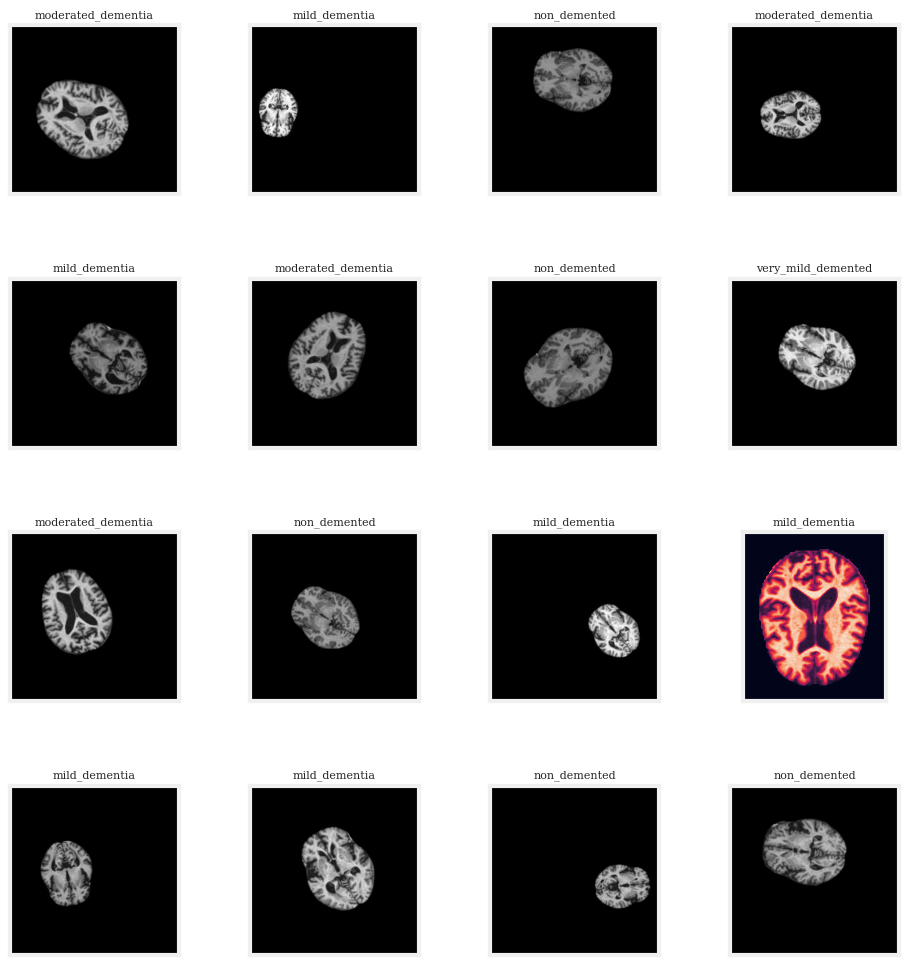

In [13]:
# Set title size and figure background color
plt.rcParams['axes.titlesize'] = 'small'  # Adjust as needed
plt.rcParams['figure.facecolor'] = 'white'  # Set figure background color to white

# Display 16 pictures of the dataset with their labels
random_index = np.random.randint(0, len(train_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[random_index[i]]))
    title = train_df.Label[random_index[i]]
    ax.set_title("\n".join(textwrap.wrap(title, 20)), fontsize=8)  # Wrap long titles
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # Increase vertical space between subplots
plt.show()


<div style="background-color:#fff1cc; padding: 20px; border-radius: 15px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1);">
    <h3 style="font-size:24px; font-family:verdana; color:#6F4E37;"><b>🧮Computing Error Rate Analysis</b></h3>
    <p style="font-size:20px; font-family:verdana; line-height: 1.7em; text-indent: 20px;">The code below is used for error level analysis (ELA) of images in the context of a animals image classification task.</p>
    <p style="font-size:20px; font-family:verdana; line-height: 1.7em; text-indent: 20px;">The compute_ela_cv() function takes an image path and a quality parameter, compresses the image using JPEG compression at the given quality, and computes the absolute difference between the compressed and original images. The difference is multiplied by a scale factor and returned as an ELA image.</p>
    <p style="font-size:20px; font-family:verdana; line-height: 1.7em; text-indent: 20px;">The convert_to_ela_image() function takes an image path and a quality parameter, compresses the image using JPEG compression at the given quality, computes the absolute difference between the compressed and original images, and returns an ELA image. The ELA image is computed using the difference in pixel values between the original and compressed images, and is normalized to enhance the differences.</p>
    <p style="font-size:20px; font-family:verdana; line-height: 1.7em; text-indent: 20px;">The random_sample() function takes a directory path and an optional file extension, and returns a random file path from that directory with the specified extension (if provided).</p>
    <p style="font-size:20px; font-family:verdana; line-height: 1.7em; text-indent: 20px;">Finally, the code generates a set of ELA images using the compute_ela_cv() function for a randomly selected image from the test dataset of animals images. The ELA images are generated with decreasing quality levels, resulting in increasing levels of compression and thus increasing levels of error. The resulting images are plotted using matplotlib.</p>
    <p style="font-size:20px; font-family:verdana; line-height: 1.7em; text-indent: 20px;">Overall, this code provides a way to visually analyze the effect of different levels of JPEG compression on animals images, and may be used to identify optimal quality levels for image compression in the context of a animals image classification task.</p>
</div>


In [14]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

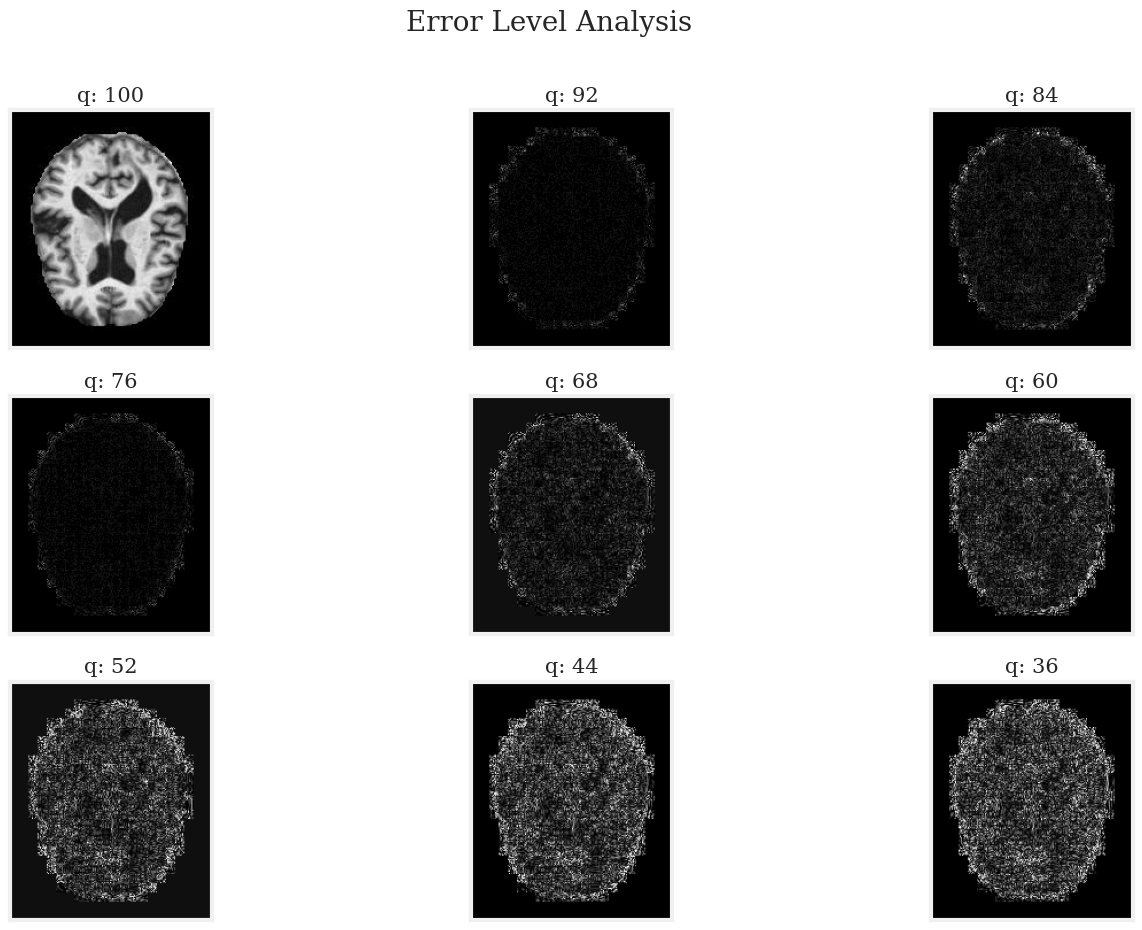

In [15]:
# View random sample from the dataset
p = random_sample('/content/drive/MyDrive/Alzheimers-image-Classification/train_images/mild_dementia')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
fig.suptitle('Error Level Analysis', fontsize=20)  # Add super title
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
    ax.set_xticks([])  # Remove x-ticks
    ax.set_yticks([])  # Remove y-ticks
plt.show()


<div style="background-color:#fff1cc; padding: 20px; border-radius: 15px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1);">
    <h3 style="font-size:24px; font-family:verdana; color:#6F4E37;"><b>📝Data Preprocessing</b></h3>
    <p style="font-size:20px; font-family:verdana; line-height: 1.7em; text-indent: 20px;">The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).</p>
</div>


In [16]:
PROCESSING_MODULE = tf.keras.applications.efficientnet_v2.preprocess_input
train_generator = ImageDataGenerator(
    preprocessing_function=PROCESSING_MODULE,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=PROCESSING_MODULE
)

In [17]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 33798 validated image filenames belonging to 4 classes.
Found 8449 validated image filenames belonging to 4 classes.
Found 1279 validated image filenames belonging to 4 classes.


<div style="background-color:#fff1cc; padding: 20px; border-radius: 15px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1);">
    <h3 style="font-size:24px; font-family:verdana; color:#6F4E37;"><b>🤹Training the model</b></h3>
  <p style="font-size:20px; font-family:verdana; line-height: 1.7em">The model images will be subjected to a pre-trained CNN model called **ResNet50**. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:</p>

  <p style="font-size:20px">
    <strong>Batch size</strong>: 32<br>
    <strong>Epochs</strong>: 100<br>
    <strong>Input Shape</strong>: (224, 224, 3)<br>
    <strong>Output layer</strong>: 8
  </p>
</div>




In [18]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    input_shape=(300, 300, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
# Create checkpoint callback
checkpoint_path = "mld_classification_model_checkpoint.weights.h5" # Add the .weights.h5 extension
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [21]:
from keras import backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [22]:
# Existing model structure
inputs = pretrained_model.input
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.45)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile with custom F1-Score
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", "mld_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/mld_classification/20241202-155613
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 12/529 ━━━━━━━━━━━━━━━━━━━━ 1:51:30 13s/step - accuracy: 0.2374 - loss: 6.1699

KeyboardInterrupt: 

In [ ]:
model.save_weights('alzheimers_mobilenet_v2.h5')

<div style="background-color:#fff1cc; padding: 20px; border-radius: 15px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1);">
    <h3 style="font-size:24px; font-family:verdana; color:#6F4E37;"><b>✔️Model Evaluation</b></h3>
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:   </p>

<h3>Precision(P):</h3>
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $P = \frac{TP}{TP+FP}$
    </span>
  </center>
</h4>


<h3>Recall(R): </h3>
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $R = \frac{TP}{TP+FN}$
    </span>
  </center>
</h4>


<h3>F1 score(F1): </h3>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $F1 = 2 \times \frac{TP \times FP}{TP + FP}$
    </span>
  </center>
</h4>
</div>

In [ ]:
results = model.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))
# print("  Test F1-score: {:.2f}%".format(results[2] * 100))

In [ ]:
import os

file_size = os.path.getsize('alzheimers_mobilenet_v2.h5') / (1024 * 1024)  # Convert bytes to MB
print(f"Model file size: {file_size:.2f} MB")

In [ ]:
total_params = model.count_params()
print(f"Total parameters: {total_params}")

# 📉Visualizing loss curves

In [ ]:
# Extracting F1-score from the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
# f1 = history.history['f1_score']
# val_f1 = history.history['val_f1_score']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))  # Create a 1x3 grid of plots

# Plot accuracy
ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.legend()

# Plot loss
ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend()

# Plot F1-score
# ax3.plot(epochs, f1, 'b', label='Training F1-score')
# ax3.plot(epochs, val_f1, 'r', label='Validation F1-score')
# ax3.set_title('Training and validation F1-score')
# ax3.legend()

plt.tight_layout()  # Adjust the padding between and around the subplots
plt.show()


# 🔮Making predictions on the Test Data

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the labelz
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

In [ ]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [ ]:
import time

start_time = time.time()
model.predict(test_images)  # or any other input, just for demonstration
end_time = time.time()

print(f"Inference time: {end_time - start_time:.2f} seconds")

<div style="background-color:#fff1cc; padding: 20px; border-radius: 15px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1);">
    <h3 style="font-size:24px; font-family:verdana; color:#6F4E37;"><b>📊Plotting the Classification Reports and Confusion Matrix</b></h3>
<p style="font-size:20px; font-family:verdana; line-height: 1.7em"><b>Confusion matrix</b> and <b>classification report</b> are two important tools used for evaluating the performance of an image classification model.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">A <b>confusion matrix</b> is a table that summarizes the number of correct and incorrect predictions made by a classification model on a set of test data. It is usually represented as a square matrix with rows and columns representing the predicted and true class labels, respectively. The entries of the matrix indicate the number of test samples that belong to a certain class, and how many of those were classified correctly or incorrectly by the model. A confusion matrix can provide a detailed breakdown of the performance of the model, including measures such as accuracy, precision, recall, and F1-score for each class. It can be used to identify specific areas where the model is making errors, and to diagnose problems with the model's predictions.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">A <b>classification report</b> is a summary of the key performance metrics for a classification model, including precision, recall, and F1-score, as well as the overall accuracy of the model. It provides a concise overview of the model's performance, typically broken down by class, and can be used to quickly assess the strengths and weaknesses of the model. The report is often presented as a table, with each row representing a class and columns showing various performance metrics. The report may also include other metrics such as support (the number of test samples belonging to a particular class), and the macro- and micro-averages of the performance metrics across all classes.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">In image classification, both confusion matrix and classification report are important tools for evaluating the performance of the model, identifying areas for improvement, and making decisions about how to adjust the model's architecture or training parameters.</p>
</div>

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# Convert labels to one-hot encoding
lb = LabelBinarizer()
y_true_onehot = lb.fit_transform(test_df.Label)

# Convert predictions to one-hot encoding
y_pred_onehot = lb.transform(pred)

# For storing average precision for each class
average_precision = {}

# Get class names
class_names = lb.classes_

# Plot PR curve for each class
n_classes = y_true_onehot.shape[1]
plt.figure(figsize=(15, 12))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_onehot[:, i], y_pred_onehot[:, i])
    average_precision[i] = average_precision_score(y_true_onehot[:, i], y_pred_onehot[:, i])

    # Printing the precision and recall values for each class using the actual class names
    print(f"Class {class_names[i]}:")
    print("Precision:", precision)
    print("Recall:", recall)
    print(f"Average Precision: {average_precision[i]:.2f}\n")

    plt.plot(recall, precision, lw=2, label=f'{class_names[i]} (average precision = {average_precision[i]:0.2f})')

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve")
plt.grid(True)
plt.show()


In [ ]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

In [ ]:
# Remove the 'accuracy' row
df = df.drop(['accuracy'])

# Remove the 'support' column
df = df.drop(['support'], axis=1)

plt.figure(figsize=(10, 10))
sns.heatmap(df, annot=True, cmap='YlOrBr')
plt.title('Classification Report Heatmap', fontsize=20)
plt.show()


In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(20, 14), text_size=10, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """
  # Create the confustion matrix

    # Use the fivethirtyeight style
    plt.style.use('fivethirtyeight')
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.YlOrBr) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


In [ ]:
# make_confusion_matrix(y_test, pred, list(labels.values()))

<div style="background-color:#fff1cc; padding: 20px; border-radius: 15px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1);">
    <h3 style="font-size:24px; font-family:verdana; color:#6F4E37;"><b>☀️Grad-Cam Visualization</b></h3>
<p style="font-size:20px; font-family:verdana; line-height: 1.7em"><b>Grad-CAM (Gradient-weighted Class Activation Mapping)</b> is a technique used to visualize the regions of an input image that were most relevant for a neural network's prediction. It allows you to see which regions of the image the model focused on while making its prediction. Grad-CAM is a modification of the CAM technique that extends the latter to any model that uses a convolutional neural network (CNN) as its underlying architecture.</p>
</div>

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path

preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "top_conv"

img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

In [ ]:
# import textwrap

# # Display the part of the pictures used by the neural network to classify the pictures
# fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
#                         subplot_kw={'xticks': [], 'yticks': []})

# for i, ax in enumerate(axes.flat):
#     img_path = test_df.Filepath.iloc[random_index[i]]
#     img_array = preprocess_input(get_img_array(img_path, size=img_size))
#     heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
#     cam_path = save_and_display_gradcam(img_path, heatmap)
#     ax.imshow(plt.imread(cam_path))

#     # Wrap the title text
#     title_text = f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}"
#     wrapped_title = '\n'.join(textwrap.wrap(title_text, 20))  # Adjust the number as needed
#     ax.set_title(wrapped_title)

# plt.tight_layout()
# plt.show()
